# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [83]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
from clean import clean

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [112]:
# Load in the data azidas
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [113]:
# Load in the data customers
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [1]:
# Create function to find out the columns with missing values
def find_missing(df):
    """Identify columns that have missing data in the dataframe
    
    Input:
        dataframe: input dataframe to identify missing data
        
    Returns:
        dataframe: dataframe of column names as index, # missing records, % missing records
    """
    
    missing_col = df.columns[df.isna().sum()>0]
    col_missing_val = df[missing_col].isna().sum().sort_values(ascending=False)
    per_missing_val = (df[missing_col].isna().sum()/df.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.DataFrame(col_missing_val,columns=['missing_number'])
    missing_df['missing_percentage']=per_missing_val
    print('Number of columns with missing data:',missing_df.shape[0])
    return missing_df

### Procedure
Step 1. Mixed-type issue fix

Step 2. Access missing value (column and row)

Step 3. Process missing value

Step 4. Remove highly correlated and redundant features

Step 5. One-hot encode and translate categorical features

### Step 1. Mixed-type data fix
According to the error messages during the data loading, columns (18, 19) in both azdias and customers dataframes exhibit mixed types issue. Therefore, this step will focus on figuring out the problem and fix it.

In [87]:
# Check the (18,19) columns in azdias dataframe
mix_column = list(azdias.iloc[:, 18:20].columns)
print("{} columns have mixed-type data issue in both azdias and customers dataframes.\n".format(mix_column))
print("The values in CAMEO_DEUG_2015 are {}\n".format(list(azdias[mix_column[0]].unique())))
print("The values in CAMEO_INTL_2015 are {}".format(list(azdias[mix_column[1]].unique())))

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] columns have mixed-type data issue in both azdias and customers dataframes.

The values in CAMEO_DEUG_2015 are [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7', '2', '8', '9', '6', '5', '1', 'X']

The values in CAMEO_INTL_2015 are [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0, '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX']


**Comments:**  The "CAMEO_DEUG_2015", "CAMEO_INTL_2015" are the columns with mixed-type data issue in two dataframes, they are caused by the appearance of "X"/"XX" and the decimal point (1 vs. 1.0) issue.

In [114]:
# Replace the "X"/"XX" by -1 in CAMEO_DEUG_2015 column and convert the data to consistent type (float) to solve mixd type issue
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'][azdias['CAMEO_DEUG_2015'].notnull()].replace("X","-1").astype('int')
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'][customers['CAMEO_DEUG_2015'].notnull()].replace("X","-1").astype('int')
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'][azdias['CAMEO_INTL_2015'].notnull()].replace("XX","-1").astype('int')
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'][customers['CAMEO_INTL_2015'].notnull()].replace("XX","-1").astype('int')

In [89]:
# Examine whether mixed type issue solved or not in azdias dataframe
azdias['CAMEO_DEUG_2015'].value_counts()

 8.0    134441
 9.0    108177
 6.0    105874
 4.0    103912
 3.0     86779
 2.0     83231
 7.0     77933
 5.0     55310
 1.0     36212
-1.0       373
Name: CAMEO_DEUG_2015, dtype: int64

In [11]:
# Examine whether mixed type issue solved or not in azdias dataframe
azdias['CAMEO_INTL_2015'].value_counts()

 51.0    133694
 41.0     92336
 24.0     91158
 14.0     62884
 43.0     56672
 54.0     45391
 25.0     39628
 22.0     33155
 23.0     26750
 13.0     26336
 45.0     26132
 55.0     23955
 52.0     20542
 31.0     19024
 34.0     18524
 15.0     16974
 44.0     14820
 12.0     13249
 35.0     10356
 32.0     10354
 33.0      9935
-1.0        373
Name: CAMEO_INTL_2015, dtype: int64

In [12]:
# Check if other columns have same mixed-type issue
azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

**Comments:** 'CAMEO_DEU_2015 also contain 'XX' value, same procedure will apply to it. 'OST_WEST_KZ' is categorical variable, will be one-hot encoding. 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM' are categorical variables with a lot of distincts, which might be one-hot encoding later or just drop.

In [115]:
# Replace the 'XX' with NaN in both azdias and customers dataframe
azdias.CAMEO_DEU_2015 = azdias.CAMEO_DEU_2015.replace('XX', np.NaN)
customers.CAMEO_DEU_2015 = customers.CAMEO_DEU_2015.replace('XX', np.NaN)

In [116]:
# Encode 'W' with 1.0, 'O' with 2.0 in OST_WEST_KZ attribute
azdias.OST_WEST_KZ = azdias.OST_WEST_KZ.replace('W', 1.0).replace('O', 2.0)
customers.OST_WEST_KZ = customers.OST_WEST_KZ.replace('W', 1.0).replace('O', 2.0)

### Step 2. Accessing missing value
In order to perform unsupervisor learning on azdias and customers dataframes in next parts, all the data should be missing value free and numeric. This step will particularly evaluate and visualize the distribution of missing value in two dataframes, sharing information about which columns/rows to impute or drop. 

#### 2.1 Accessing missing value in each colums of azidas dataframe

In [117]:
# Find out the missing value in each columns of azdias dataframe
azdias_missing_col = find_missing(azdias)
azdias_missing_col.head(20)

Number of columns with missing data: 273


,missing_number,missing_percentage
ALTER_KIND4,890016,99.864792
ALTER_KIND3,885051,99.307691
ALTER_KIND2,861722,96.690047
ALTER_KIND1,810163,90.904837
EXTSEL992,654153,73.399639
KK_KUNDENTYP,584612,65.596749
ALTERSKATEGORIE_FEIN,262947,29.504130
D19_SOZIALES,257113,28.849522
D19_VERSI_ONLINE_QUOTE_12,257113,28.849522
D19_VERSAND_ONLINE_QUOTE_12,257113,28.849522


(array([ 50., 207.,  10.,   0.,   0.,   0.,   1.,   1.,   0.,   4.]),
 array([ 0.54464605, 10.47666067, 20.40867529, 30.34068991, 40.27270453,
        50.20471914, 60.13673376, 70.06874838, 80.000763  , 89.93277762,
        99.86479223]),
 <a list of 10 Patch objects>)

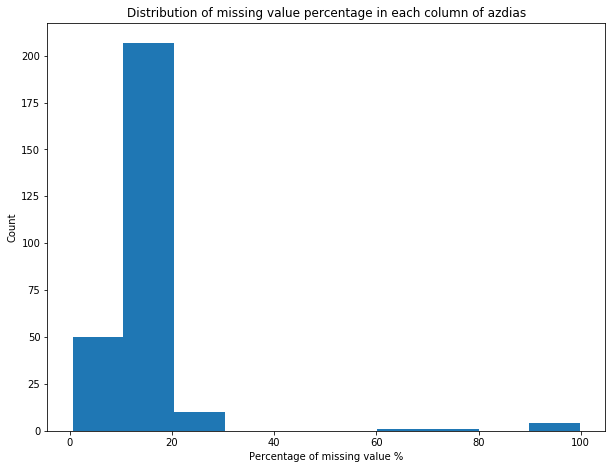

In [18]:
# Visualize the distribution of missing value percentage in each columns of azdias
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot()
ax.set_title('Distribution of missing value percentage in each column of azdias')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('Count')
plt.hist(azdias_missing_col['missing_percentage'])

<BarContainer object of 30 artists>

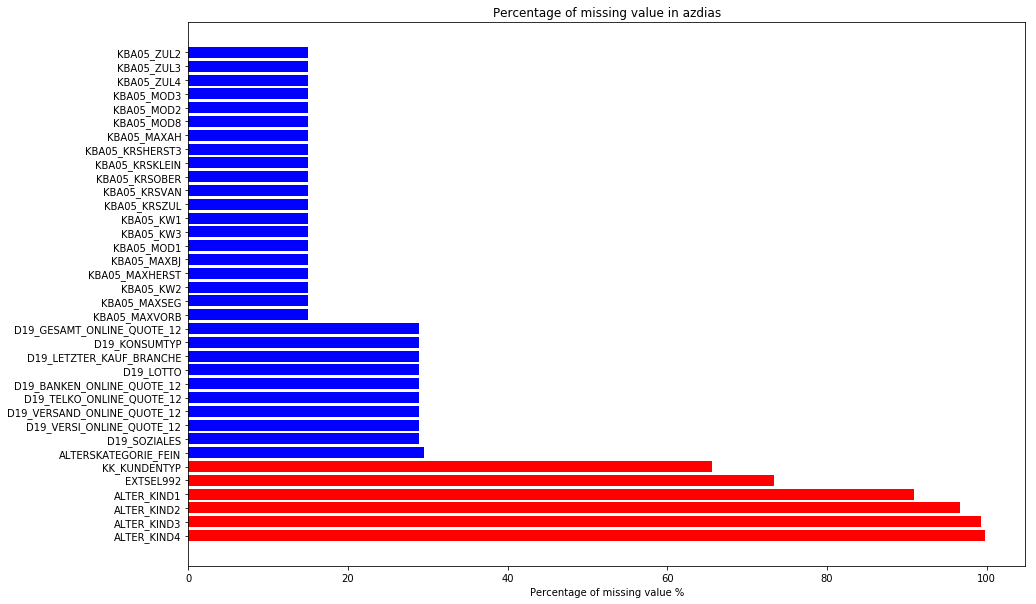

In [19]:
# Visualize the missing value in each columns of azdias
sub_a = azdias_missing_col[azdias_missing_col['missing_percentage']>40]
sub_b = azdias_missing_col[azdias_missing_col['missing_percentage']<=40][:30]

fig = plt.figure(figsize=[15,10])
ax = plt.subplot()
ax.set_title('Percentage of missing value in azdias')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('')
plt.barh(sub_a.index.values, sub_a['missing_percentage'], color='r')
plt.barh(sub_b.index.values, sub_b['missing_percentage'], color='b')

**Discussion:** In azdias dataframe, there are 273 out of 366 columns containing missing values, most of them are around 20% missing rate (blue color bar), which require further data manipulation (impute or drop). While those features (labelled with red color), have over 60% data missing rate, which are harmful for building machine learning model, should be directly dropped in the further data processing.

#### 2.2 Accessing missing value in each rows of azdias dataframe

In [20]:
# Evaluate the missing percentage in each row of azdias
missing_row_per = azdias.isna().sum(axis=1).sort_values(ascending=False)/366*100

(array([7.48418e+05, 2.91300e+03, 2.57330e+04, 8.33400e+03, 2.82300e+03,
        3.75900e+03, 8.00000e+00, 5.82800e+03, 1.51300e+04, 7.82750e+04]),
 array([ 0.        ,  7.07650273, 14.15300546, 21.2295082 , 28.30601093,
        35.38251366, 42.45901639, 49.53551913, 56.61202186, 63.68852459,
        70.76502732]),
 <a list of 10 Patch objects>)

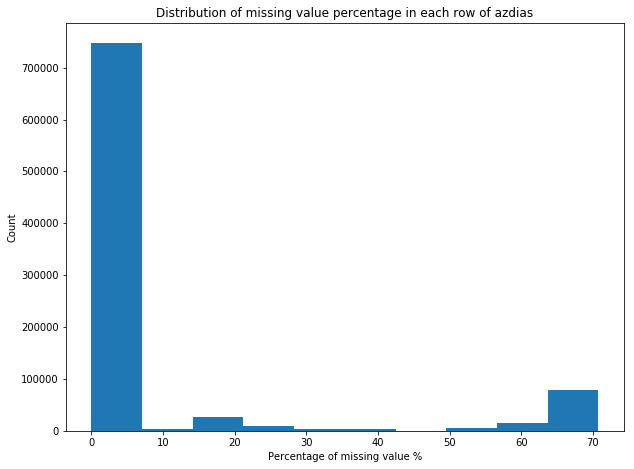

In [21]:
# Visualize the distribution of missing value percentage in each rows of azdias
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot()
ax.set_title('Distribution of missing value percentage in each row of azdias')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('Count')
plt.hist(missing_row_per)

**Discussion:** From above histogram, we can see almost every single row has missing value, there are quite significant amount of rows with over 50% missing value, which should be considered dropping to avoid introducing bias for the future model building.

#### 2.3 Accessing missing value in each colums of customers dataframe

In [118]:
#Drop three extra columns in customers
customers = customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

# Find out the missing value in each columns of customers dataframe
customers_missing_col = find_missing(customers)
customers_missing_col.head(20)

Number of columns with missing data: 273


,missing_number,missing_percentage
ALTER_KIND4,191416,99.876860
ALTER_KIND3,190377,99.334732
ALTER_KIND2,186552,97.338927
ALTER_KIND1,179886,93.860748
KK_KUNDENTYP,111937,58.406382
EXTSEL992,85283,44.498883
KBA05_ANHANG,55980,29.209192
KBA05_MAXHERST,55980,29.209192
KBA05_ALTER2,55980,29.209192
KBA05_MOD8,55980,29.209192


(array([ 17.,   0., 251.,   3.,   3.,   5.,   1.,   0.,   1.,  10.]),
 array([ 0.12522697, 10.10039029, 20.07555361, 30.05071692, 40.02588024,
        50.00104356, 59.97620687, 69.95137019, 79.92653351, 89.90169683,
        99.87686014]),
 <a list of 10 Patch objects>)

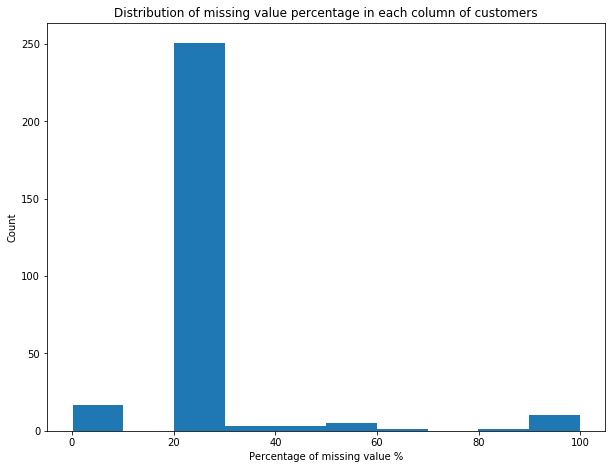

In [23]:
# Visualize the distribution of missing value percentage in each columns of customers
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot()
ax.set_title('Distribution of missing value percentage in each column of customers')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('Count')
plt.hist(customers_missing_col['missing_percentage'])

<BarContainer object of 30 artists>

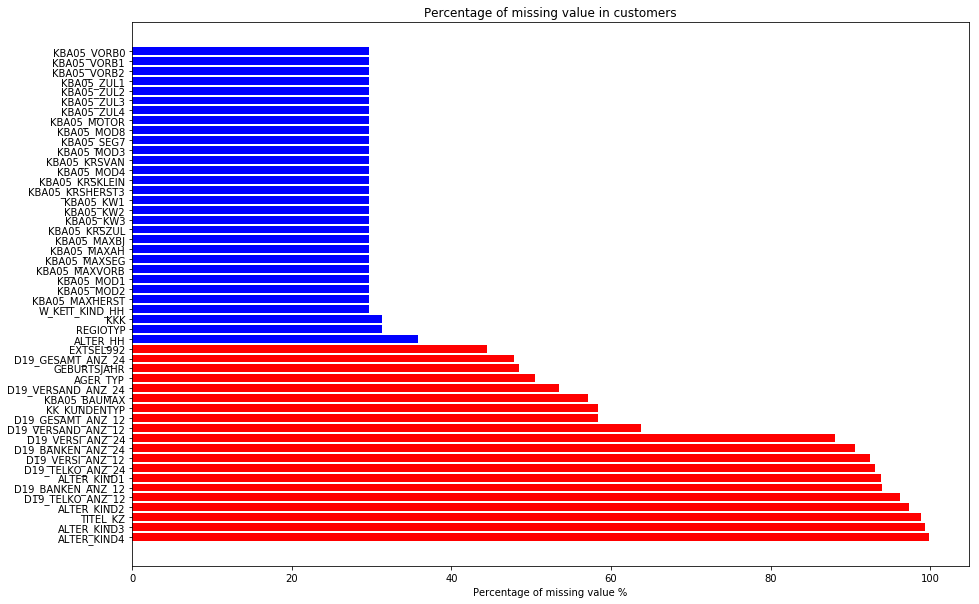

In [24]:
# Visualize the missing value in each columns of azdias
sub_a = customers_missing_col[customers_missing_col['missing_percentage']>40]
sub_b = customers_missing_col[customers_missing_col['missing_percentage']<=40][:30]

fig = plt.figure(figsize=[15,10])
ax = plt.subplot()
ax.set_title('Percentage of missing value in customers')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('')
plt.barh(sub_a.index.values, sub_a['missing_percentage'], color='r')
plt.barh(sub_b.index.values, sub_b['missing_percentage'], color='b')

**Discussion:** Similarly, there are same six features (red bar): "EXTSEL992","KK_KUNDENTYP", "ALTER_KIND1", "ALTER_KIND2", "ALTER_KIND3", and "ALTER_KIND4", have over 40% missing value rate in customers dataframe, should be directly dropped. While a bit different from azdias, there are quite amount of features have missing value rate between 20-40%, need further consideration.

#### 2.4 Accessing missing value in each rows of customers dataframe

In [25]:
# Evaluate the missing percentage in each row of customers
customers_missing_row_per = customers.isna().sum(axis=1).sort_values(ascending=False)/366*100

(array([1.30559e+05, 3.68400e+03, 4.56700e+03, 1.55100e+03, 2.01000e+02,
        3.00000e+02, 8.00000e+00, 8.41000e+02, 3.22800e+03, 4.67130e+04]),
 array([ 0.27322404,  7.75956284, 15.24590164, 22.73224044, 30.21857923,
        37.70491803, 45.19125683, 52.67759563, 60.16393443, 67.65027322,
        75.13661202]),
 <a list of 10 Patch objects>)

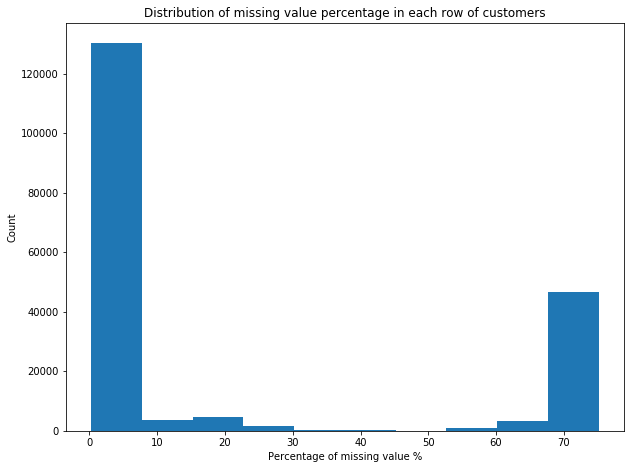

In [26]:
# Visualize the distribution of missing value percentage in each rows of customers
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot()
ax.set_title('Distribution of missing value percentage in each row of customers')
ax.set_xlabel('Percentage of missing value %')
ax.set_ylabel('Count')
plt.hist(customers_missing_row_per)

**Discussion:** The missing value situation is similar with the rows in azdias, there are quite significant amount of rows with over 50% missing value, the missing value processing strategy should be consistent with that of azdias dataframe.

### Step 3. Processing missing value
This step will focus on handling the missing value in each columns and rows, the threshold for column is >30% missing rate, for row is >50% missing rate. 

But before removing missing value, I will first convert the missing/unknown value to NaN, e.g. 'AGER_TYP', its missing/unknown values were labeled as -1 and 0.

In [93]:
# Load feature_summary dataframe
feature = pd.read_csv('./feature_summary.csv')
feature.drop(['Unnamed: 0'],axis=1, inplace=True)
feature.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"-1, 0"
1,ALTERSKATEGORIE_GROB,ordinal,"-1, 0, 9"
2,ANREDE_KZ,categorical,"-1, 0"
3,CJT_GESAMTTYP,categorical,0
4,FINANZ_MINIMALIST,ordinal,-1


In [94]:
# Split the value in missing_or_unknown column, convert them into numeric variable
feature_notnull = feature[feature['missing_or_unknown'].notna()]
feature_notnull['missing_or_unknown'] = feature_notnull['missing_or_unknown'].apply(lambda x: x.split(','))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
# Re-encode the unknown value in each attribute as NaN based the information from feature_summary dataframe

# Iterate through each attribute in feature
for i in feature_notnull.index:
    # Convert each value in missing_or_unknown to 'int' variable if there is
    for value in range(len(feature_notnull.loc[i,'missing_or_unknown'])):
        feature_notnull.loc[i,'missing_or_unknown'][value] = int(feature_notnull.loc[i,'missing_or_unknown'][value])

    # Replace the unknown or missing value to NaN in azdias in the reference of feature dataframe
    azdias.loc[:,(feature_notnull.loc[i, 'attribute'])].replace(feature_notnull.loc[i,'missing_or_unknown'], np.nan, inplace=True)
    customers.loc[:,(feature_notnull.loc[i, 'attribute'])].replace(feature_notnull.loc[i,'missing_or_unknown'], np.nan, inplace=True)

In [122]:
# Evaluate the missing value in each columns of azdias dataframe after missing_or_unknown re-encoding
azdias_missing_col_impute = find_missing(azdias)
azdias_missing_col_impute.head(20)

Number of columns with missing data: 291


,missing_number,missing_percentage
ALTER_KIND4,890016,99.864792
TITEL_KZ,889061,99.757636
ALTER_KIND3,885051,99.307691
ALTER_KIND2,861722,96.690047
D19_TELKO_ANZ_12,857990,96.271295
D19_BANKEN_ANZ_12,831734,93.325225
D19_TELKO_ANZ_24,826208,92.705176
D19_VERSI_ANZ_12,821289,92.153237
ALTER_KIND1,810163,90.904837
D19_BANKEN_ANZ_24,794100,89.102479


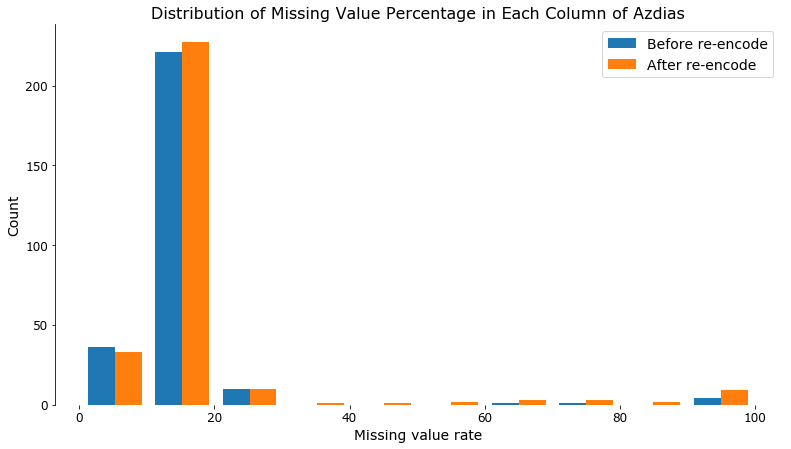

In [306]:
# Compare the distribution of missing value percentage change before and after NaN value re-encode in azdias
fig = plt.figure(figsize=[13,7])
ax = plt.subplot()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.set_title('Distribution of Missing Value Percentage in Each Column of Azdias',fontname="verdana").set_size(16)
ax.set_xlabel('Missing value rate', fontname="verdana").set_size(14)
ax.set_ylabel('Count',fontname="verdana").set_size(14)
plt.xticks(fontsize=12, fontname="verdana")
plt.yticks(fontsize=12, fontname="verdana")
labels = ['Before re-encode', 'After re-encode']
plt.hist([azdias_missing_col['missing_percentage'], azdias_missing_col_impute['missing_percentage']], label = labels)
ax.legend(prop={'size': 14}, loc='upper right')
plt.savefig('missing rate.png', bbox_inches='tight')

In [303]:
# Evaluate the missing value in each columns of customers dataframe after missing_or_unknown re-encoding
customers_missing_col_impute = find_missing(customers)
customers_missing_col_impute.head(20)

Number of columns with missing data: 291


,missing_number,missing_percentage
ALTER_KIND4,191416,99.876860
ALTER_KIND3,190377,99.334732
TITEL_KZ,189340,98.793647
ALTER_KIND2,186552,97.338927
D19_TELKO_ANZ_12,184467,96.251017
D19_BANKEN_ANZ_12,180150,93.998497
ALTER_KIND1,179886,93.860748
D19_TELKO_ANZ_24,178411,93.091123
D19_VERSI_ANZ_12,177236,92.478033
D19_BANKEN_ANZ_24,173701,90.633544


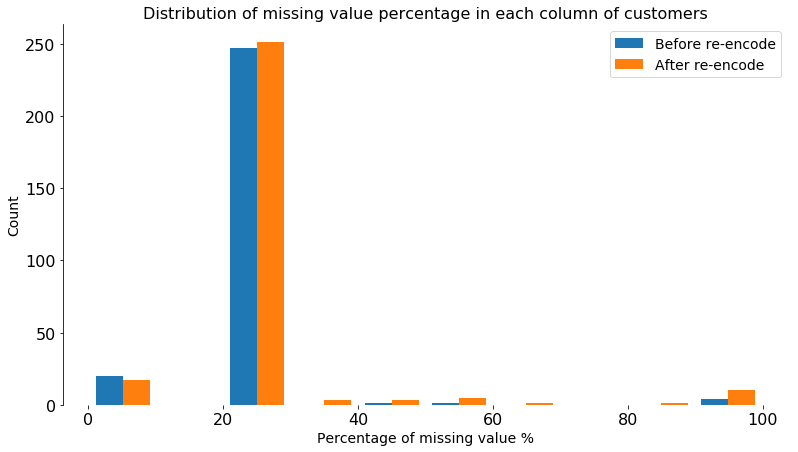

In [295]:
# Visualize the distribution of missing value percentage change before and after NaN value re-encode in customers
fig = plt.figure(figsize=[13,7])
ax = plt.subplot()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.set_title('Distribution of missing value percentage in each column of customers').set_size(16)
ax.set_xlabel('Percentage of missing value %').set_size(14)
ax.set_ylabel('Count').set_size(14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
labels = ['Before re-encode', 'After re-encode']
plt.hist([customers_missing_col['missing_percentage'], customers_missing_col_impute['missing_percentage']], label = labels)
ax.legend(prop={'size': 14}, loc='upper right')

**Comments:** After re-encoding missing/unknown value, the distribution of missing value in both Azdias and Customers shift toward higher percentage area, therefore, the next step is to directly drop columns with over 30% missing rate in both dataframes.

In [124]:
# Drop Column with >30 NaN rate in azdias and customers dataframe
drop_missing = azdias_missing_col_impute[azdias_missing_col_impute['missing_percentage']>30].index
azdias_drop_missing = azdias.drop(columns=drop_missing)
customers_drop_missing = customers.drop(columns=drop_missing)
print('There are {} columns in azdias after column dropping'.format(azdias_drop_missing.shape[1]))
print('There are {} columns in customers after column dropping'.format(customers_drop_missing.shape[1]))

There are 345 columns in azdias after column dropping
There are 345 columns in customers after column dropping


In [125]:
print(drop_missing)

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2',
       'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_VERSI_ANZ_12', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24',
       'D19_VERSI_ANZ_24', 'AGER_TYP', 'EXTSEL992', 'D19_VERSAND_ANZ_12',
       'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24',
       'D19_GESAMT_ANZ_24', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'],
      dtype='object')


### Step 4. Remove highly correlated and redundant features
In this step, the correlation coefficient of each features will be calculated in both dataframe.

Any features with over 0.95 correlation coefficient will be dropped.

Also, features "CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, and EINGEFUEGT_AM" will be dropped due to too many distinct attributes. 

#### 4.1 Remove highly correlated features

In [126]:
# Create positive correlation matrix
corr_df = azdias_drop_missing.corr().abs()

# Creat and apply mask
mask = np.triu(np.ones_like(corr_df,dtype=bool))
tri_df = corr_df.mask(mask)

In [127]:
# Find the columns that meet treshold
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]
len(to_drop)

12

In [153]:
print(to_drop)

['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEUG_2015', 'D19_VERSAND_DATUM', 'KBA13_BAUMAX', 'KBA13_FAB_SONSTIGE', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_211', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']


In [183]:
# Print out the the correlation (Pearson’s R)
tri_df.unstack().sort_values(ascending=False)[:14]

KBA13_FAB_SONSTIGE   KBA13_HERST_SONST             1.000000
LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB           0.990153
LP_FAMILIE_FEIN      LP_FAMILIE_GROB               0.988211
LP_STATUS_FEIN       LP_STATUS_GROB                0.982411
KBA13_GBZ            PLZ8_GBZ                      0.979854
ANZ_HAUSHALTE_AKTIV  ANZ_STATISTISCHE_HAUSHALTE    0.976887
LP_FAMILIE_GROB      LP_LEBENSPHASE_GROB           0.971096
KBA13_HHZ            PLZ8_HHZ                      0.968725
KBA13_KMH_211        KBA13_KMH_250                 0.960155
LP_FAMILIE_FEIN      LP_LEBENSPHASE_GROB           0.959766
D19_VERSAND_DATUM    D19_VERSAND_ONLINE_DATUM      0.957753
CAMEO_DEUG_2015      CAMEO_INTL_2015               0.955588
LP_FAMILIE_GROB      LP_LEBENSPHASE_FEIN           0.953949
KBA13_BAUMAX         PLZ8_BAUMAX                   0.950527
dtype: float64

In [40]:
# Drop the highly correlated features in both azdias and customers
azdias_drop_corr = azdias_drop_missing.drop(to_drop, axis=1)
customers_drop_corr = customers_drop_missing.drop(to_drop, axis=1)

In [41]:
print("There are {} columns".format(azdias_drop_corr.shape[1]))

There are 333 columns


#### 4.2 Drop redundant features (with too many distinct attributes)

In [ ]:
# Drop CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, and EINGEFUEGT_AM from orginal df
azdias_drop_corr.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)
customers_drop_corr.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)

In [44]:
# Drop the row with > 50% missing value
azdias_drop_corr = azdias_drop_corr[azdias_drop_corr.isnull().sum(axis=1) <= 0.5 * azdias_drop_corr.shape[1]].reset_index(drop=True)
customers_drop_corr = customers_drop_corr[customers_drop_corr.isnull().sum(axis=1) <= 0.5*335].reset_index(drop=True)

In [45]:
print("There are {} row".format(azdias_drop_corr.shape[0]))

There are 791244 row


### Step 5. One-hot encode and translate categorical features

This step will divide categorical features into binary and multilevel variables. Binary features will keep untouch, and convert multilevel categorical features into dummie variables.

Some features possess more than one dimensional meanings, such as 'CAMEO_INTL_2015' represent wealth and life stage. Therefore, they will be split and translated into new independent features.

#### Step 5.1 Get dummies for multilevel categorical variables

In [46]:
# Identify binary and multilevel categorical variables
cat_col = feature[feature['type']=='categorical']['attribute']
cat_col = [x for x in cat_col if x in azdias_drop_corr.columns]
binary = []
multilevel = []

for col in cat_col:
    if azdias_drop_corr[col].nunique() == 2:
        binary.append(col)
    if (azdias_drop_corr[col].nunique() > 2) & (azdias_drop_corr[col].nunique() < 30):
        multilevel.append(col)

In [47]:
print(multilevel)

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP']

In [49]:
# Get dummie for multilevel feature, keep binary untouch
for feature in multilevel:
    #Get dummie for azdias
    azdias_notnull = azdias_drop_corr[feature][azdias_drop_corr[feature].notnull()]
    dummie_azdias = pd.get_dummies(azdias_notnull,prefix=feature)
    azdias_drop_corr.drop(feature, axis=1, inplace=True)
    azdias_drop_corr = pd.concat([azdias_drop_corr, dummie_azdias], axis = 1)
    # Get dummie for customer
    customers_notnull = customers_drop_corr[feature][customers_drop_corr[feature].notnull()]
    dummie_customers = pd.get_dummies(customers_notnull,prefix=feature)
    customers_drop_corr.drop(feature, axis=1, inplace=True)
    customers_drop_corr = pd.concat([customers_drop_corr, dummie_customers], axis = 1)

#### Step 5.2 Translate multi-dimensional variables

In [50]:
# Identify the mixed-type features
mix_col = ['LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015','PLZ8_BAUMAX']

PRAEGENDE_JUGENDJAHRE: dominating movement in the person's youth (avantgarde or mainstream)

CAMEO_INTL_2015: wealth and life stage

In [53]:
# Re-encode PRAEGENDE_JUGENDJAHRE into two dimensions, 1. decades 2. movement (avantgarde or mainstream)
decade = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90,
           np.nan: np.nan, -1: np.nan, 0: np.nan}
# mainstream 0, avantgarde 1
movement = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}
azdias_drop_corr['Decade'] = azdias_drop_corr['PRAEGENDE_JUGENDJAHRE'].map(decade)
customers_drop_corr['Decade'] = customers_drop_corr['PRAEGENDE_JUGENDJAHRE'].map(decade)
azdias_drop_corr['Movement'] = azdias_drop_corr['PRAEGENDE_JUGENDJAHRE'].map(movement)
customers_drop_corr['Movement'] = customers_drop_corr['PRAEGENDE_JUGENDJAHRE'].map(movement)

In [54]:
# CAMEO_INTL_2015 is two-digit number, first digit represent wealth, second represent life stage.
# Break into two new variable by each digit
wealth = {11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 
         41: 4, 42: 4, 43: 4, 44: 4, 45: 4, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, -1: np.nan}
life_stage = {11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 21: 1, 22: 2, 23: 3, 24: 4, 25: 5, 31: 1, 32: 2, 33: 3, 34: 4, 35: 5,
             41: 1, 42: 2, 43: 3, 44: 4, 45: 5, 51: 1, 52: 2, 53: 3, 54: 4, 55: 5, -1: np.nan}
azdias_drop_corr['Wealth'] = azdias_drop_corr['CAMEO_INTL_2015'].map(wealth)
customers_drop_corr['Wealth'] = customers_drop_corr['CAMEO_INTL_2015'].map(wealth)
azdias_drop_corr['Life_stage'] = azdias_drop_corr['CAMEO_INTL_2015'].map(life_stage)
customers_drop_corr['Life_stage'] = customers_drop_corr['CAMEO_INTL_2015'].map(life_stage)

In [55]:
# Get dummies for rest of mixed-type features
mix_dummies = ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
for feature in mix_dummies:
    #Get dummie for azdias
    azdias_notnull = azdias_drop_corr[feature][azdias_drop_corr[feature].notnull()]
    dummie_azdias = pd.get_dummies(azdias_notnull,prefix=feature)
    azdias_drop_corr = pd.concat([azdias_drop_corr, dummie_azdias], axis = 1)
    customers_notnull = customers_drop_corr[feature][customers_drop_corr[feature].notnull()]
    dummie_customers = pd.get_dummies(customers_notnull,prefix=feature)
    customers_drop_corr = pd.concat([customers_drop_corr, dummie_customers], axis = 1)

In [56]:
# Drop original mixed-type features
azdias_clean = azdias_drop_corr.drop(mix_col, axis=1)
customers_clean = customers_drop_corr.drop(mix_col, axis=1)

In [57]:
# Check if azidas has same columns as customer dataframe
print(np.setdiff1d(azdias_clean.columns,customers_clean.columns))

['GEBAEUDETYP_5.0']


In [58]:
# Create the missing column in Customers
customers_clean['GEBAEUDETYP_5.0'] = 0
customers_clean['GEBAEUDETYP_5.0'] = customers_clean['GEBAEUDETYP_5.0'].astype('uint8')

In [61]:
# Save the clean dataframe as pickle files
azdias_clean.to_pickle('./azdias_clean.pkl')
customers_clean.to_pickle('./customers_clean.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Step 1. Principal component analysis (PCA)

In [4]:
# Load cleaned azdias dataframe and impute the missing value with 'mode'
azdias_clean = pd.read_pickle('./azdias_clean.pkl')
imputer = SimpleImputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean.values), columns= azdias_clean.columns)

In [5]:
# Check if there are any missing value in dataframe
find_missing(azdias_imputed)

Number of columns with missing data: 0


,missing_number,missing_percentage


In [5]:
# Scale the data by Standard Scaler
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed.values),columns=azdias_imputed.columns)

In [265]:
# Apply a PCA to azdias
pca = PCA(random_state=42)
azdias_pca = pca.fit_transform(azdias_scaled)

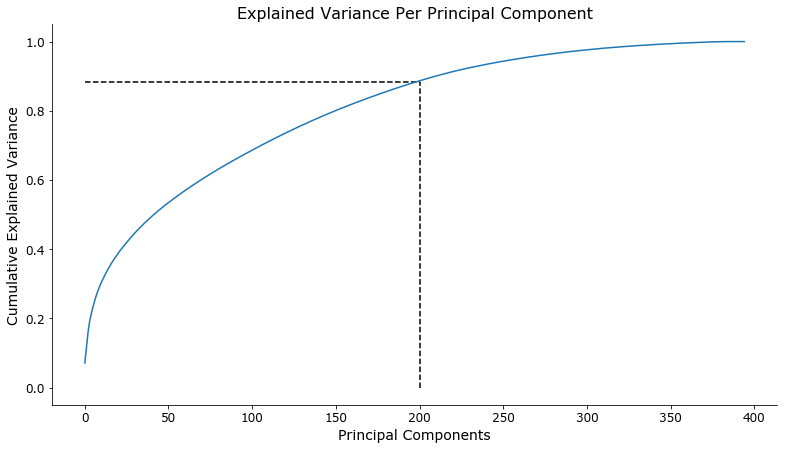

In [307]:
# Visualize the explained variance distribution
fig = plt.figure(figsize=[13,7])
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('Cumulative Explained Variance',fontname="verdana").set_size(14)
plt.xlabel('Principal Components', fontname="verdana").set_size(14)
plt.title('Explained Variance Per Principal Component', fontname="verdana").set_size(16)
plt.xticks(fontsize=12, fontname="verdana")
plt.yticks(fontsize=12, fontname="verdana")
ax.plot(np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y=0.883204071091655, xmin=0, xmax=200, color='black', linestyles='--')
plt.vlines(x=200, ymin=0, ymax=0.883204071091655, color='black', linestyles='--')
plt.savefig('PCA.png', bbox_inches='tight')
plt.show()

**Discussion:** From the plot, we can see when the principal components reduce to 200, it can still achieve around 88% variance of original data. So I decide to take the number of principal component as 200, re-fit into the azdias data.

In [207]:
# Re-fit the data with 200 principal components
n_components=200
pca = PCA(n_components=n_components,random_state=42)
azdias_pca = pca.fit_transform(azdias_scaled)

In [208]:
print(sum(pca.explained_variance_ratio_))

0.883204071091655


In [209]:
# Repeat same procedures for customers dataset
customers_clean = pd.read_pickle('./customers_clean.pkl')
customers_imputed = pd.DataFrame(imputer.transform(customers_clean.values), columns= customers_clean.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed.values),columns=customers_imputed.columns)

In [210]:
# Apply PCA to customers
customers_pca = pca.transform(customers_scaled)

#### Step 2. Determine the number of cluster by elbow method

In [211]:
# Number of different cluster counts
n_clusters = np.arange(2,21)
# run k-means clustering on the data and compute the average within-cluster distances.
scores = [MiniBatchKMeans(i).fit(azdias_pca).score(azdias_pca) for i in n_clusters]

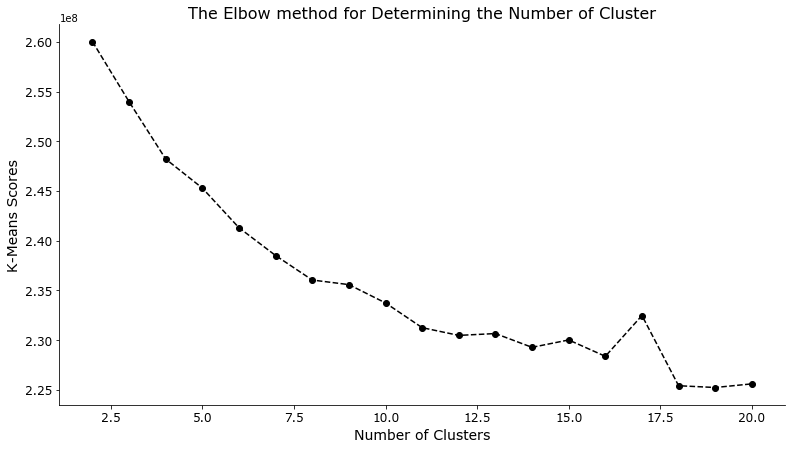

In [308]:
# Visualize the score and cluster number
fig = plt.figure(figsize=[13,7])
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('K-Means Scores', fontname="verdana").set_size(14)
plt.xlabel('Number of Clusters', fontname="verdana").set_size(14)
plt.title('The Elbow method for Determining the Number of Cluster', fontname="verdana").set_size(16)
plt.xticks(fontsize=12, fontname="verdana")
plt.yticks(fontsize=12, fontname="verdana")
ax.plot(n_clusters, np.abs(scores), linestyle='--', marker='o', color='black');
plt.savefig('Elbow.png', bbox_inches='tight')

**Discussion:** From the result, we can see a significant elbow point appear at 8. So I took 8 as the optimal cluster number.

In [216]:
# Re-fit k-means model with 8 number of clusters
model = KMeans(n_clusters=8, random_state=42)
azdias_preds = model.fit_predict(azdias_pca)
customers_preds = model.predict(customers_pca)

#### Step 3. Clustering

In [217]:
# Store the demographics information in each cluster
counts_population = pd.Series(azdias_preds).value_counts().sort_index()

prop_population = []
for value in counts_population:
    prop = value / len(azdias_preds)
    prop_population.append(prop)

prop_population = pd.Series(prop_population)

In [218]:
# Store the customer information in each cluster
counts_customers = pd.Series(customers_preds).value_counts().sort_index()

prop_customers = []
for value in counts_customers:
    prop = value / len(customers_preds)
    prop_customers.append(prop)

prop_customers = pd.Series(prop_customers)

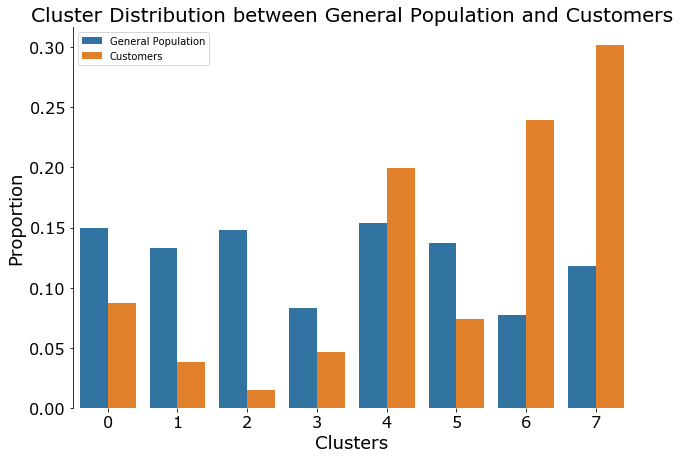

In [311]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

prop_distribution = pd.DataFrame({'Cluster': [0,1,2,3,4,5,6,7], 'General Population': prop_population,
                     'Customers': prop_customers})
pro_plot = prop_distribution.melt(id_vars = "Cluster", var_name='cols',  value_name='vals')
fig = plt.figure(figsize=(10,7))
ax = sns.barplot(x='Cluster', y="vals", hue='cols', data=pro_plot)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:])
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('Proportion', fontname="verdana").set_size(18)
plt.xlabel('Clusters', fontname="verdana").set_size(18)
plt.xticks(fontsize=16, fontname="verdana")
plt.yticks(fontsize=16, fontname="verdana")
plt.title('Cluster Distribution between General Population and Customers', fontname="verdana").set_size(20)
plt.savefig('Prob distribution.png',bbox_inches='tight')

In [255]:
# Compute the proportional difference between general population and customers
diff = prop_customers - prop_population
diff_df = pd.DataFrame(columns=['Cluster', 'Difference'])
for i, j in diff.items():
    diff_df = diff_df.append({"Cluster": i, "Difference": j}, ignore_index=True)

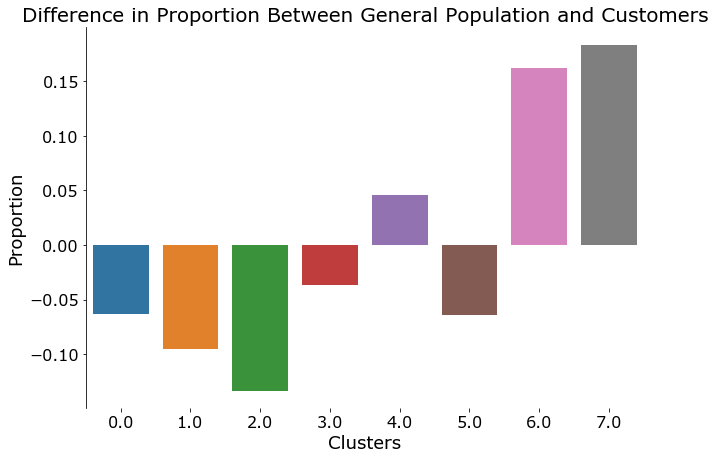

In [316]:
# Visualize the difference
fig = plt.figure(figsize=(10,7))
ax = sns.barplot(x = diff_df['Cluster'], y = diff_df['Difference'])
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('Proportion', fontname="verdana").set_size(18)
plt.xlabel('Clusters', fontname="verdana").set_size(18)
plt.xticks(fontsize=16, fontname="verdana")
plt.yticks(fontsize=16, fontname="verdana")
plt.title('Difference in Proportion Between General Population and Customers', fontname="verdana").set_size(20)
plt.savefig('difference.png', bbox_inches='tight')

**Discussion:** Cluster 7 is the major customers base in the company, since it has the highest customer proportion among the others, can be considered as the loyal customer of company. While in Cluster 2, it not only shows lowest customer percentage, but also exhibits highest negative difference between general population and customers proportion, indicating that very small portion of general population in Cluster 2 have become the customer of company. However, if the company adapt a more tailored marketing strategy on Cluster 2, they have the highest potential to become new customers in the future. 

#### Step 4. Decomposition Cluster 7 and 2

In [16]:
def finding_components(n_cluster, n_components, model = model):
    """
    Finding the most important components in specified cluster.
    
    INPUT:
    - n_cluster (int): number of cluster to be evaluated
    - n_components (int): number of top important components
    - model: k-means method model       
    OUTPUT:
    - components (series): containing component number and its explained_variance_ratio
    """
    center = model.cluster_centers_[n_cluster]
    center = pd.Series(center)
    center.index = center.index+1
    components = list(center.sort_values(ascending=False)[:n_components].index)
    return components

In [62]:
def finding_features(n_components, n_features):
    """
    Finding the most important features in specified principal component.
    
    INPUT:
    - n_components (list): number of component to be evaluated
    - n_features (int): number of top important features      
    OUTPUT:
    - positive_features (list): positive related features
    - negative_features (list): negative related features
    """
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    weights = pd.DataFrame(pca.components_, columns = azdias_clean.columns.values)
    df = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    positive_features = df.iloc[(n_components)-1].sort_values(ascending=False)[:n_features]
    negative_features = df.iloc[(n_components)-1].sort_values()[:n_features]
    return positive_features, negative_features

In [18]:
def feature_value(positive_features, negative_features, n_cluster):
    """
    Finding the value of most important positive&negative features in specified cluster
    
    INPUT:
    - positive_features (list): list of positive related features
    - negative_feature (list): list of negative related features
    - n_cluster (int): number of cluster to be evaluated
            
    OUTPUT:
    - df_positive (dataframe): containing positive features and their values
    - df_negative (dataframe): containing negative features and their values
    """
    center = model.cluster_centers_[n_cluster]
    center_inv = scaler.inverse_transform(pca.inverse_transform(center))
    df = pd.DataFrame({'Features': azdias_clean.columns, 'Values': center_inv}).sort_values('Values', axis=0, ascending=False)
    df_positive = df[df['Features'].isin(positive_features)]
    df_negative = df[df['Features'].isin(negative_features)]
    return df_positive, df_negative

In [63]:
def cluster_evaluation(n_cluster, n_component, n_feature):
    """
    Evaluate the important features for certain cluster, and their feature values
    
    INPUT:
    - n_cluster (int): number of cluster want to study
    - n_component (int): number of component to be included
    - n_feature (int): number of features to be included
            
    OUTPUT:
    - df_positive (dataframe): containing positive features and their values
    - df_negative (dataframe): containing negative features and their values
    """
    pc = finding_components(n_cluster, n_component)
    p_total = []
    n_total = []
    for i in pc:
        p,n = finding_features(i,n_feature)
        p_df, n_df= feature_value(p.index,n.index,n_cluster)
        p_total.append(p_df)
        n_total.append(n_df)
    df_positive = pd.concat(p_total)
    df_negative = pd.concat(n_total)
    
    return df_positive, df_negative

In [64]:
# Decomposition Cluster 7
cluster7_p, cluster7_n = cluster_evaluation(7,2,5)

In [65]:
# The positively correlated feature for Cluster 7
cluster7_p

,Features,Values
271,MOBI_REGIO,4.056093
270,MOBI_RASTER,3.299245
275,PLZ8_ANTG1,2.821930
158,KBA13_ANTG1,2.669072
390,PLZ8_BAUMAX_1.0,0.914532
81,FINANZ_VORSORGER,4.533464
15,CJT_TYP_5,4.294945
16,CJT_TYP_6,4.257022
14,CJT_TYP_4,4.175917
316,ALTERSKATEGORIE_GROB,3.421129


In [66]:
# The negatively correlated feature for Cluster 7
cluster7_n

,Features,Values
160,KBA13_ANTG3,1.207602
277,PLZ8_ANTG3,1.184289
278,PLZ8_ANTG4,0.374351
161,KBA13_ANTG4,0.353822
341,LP_STATUS_GROB_1.0,0.041462
366,Decade,62.471505
11,CJT_TYP_1,2.218762
12,CJT_TYP_2,1.920328
76,FINANZ_ANLEGER,1.568542
79,FINANZ_SPARER,1.392866


In [53]:
# Decomposition Cluster 2
cluster2_p, cluster2_n = cluster_evaluation(2,2,5)

In [54]:
# The positively correlated feature for Cluster 2
cluster2_p

,Features,Values
255,KBA13_SITZE_4,3.239386
234,KBA13_MERCEDES,3.229907
248,KBA13_SEG_OBEREMITTELKLASSE,3.210867
201,KBA13_HERST_BMW_BENZ,3.207910
171,KBA13_BMW,3.157282
259,KBA13_VORB_0,3.175583
210,KBA13_KMH_210,3.125993
229,KBA13_KW_61_120,3.110769
176,KBA13_CCM_1401_2500,3.005075
274,OST_WEST_KZ,1.088671


In [55]:
# The negatively correlated feature for Cluster 7
cluster2_n

,Features,Values
243,KBA13_SEG_KLEINWAGEN,2.891740
189,KBA13_HALTER_25,2.863392
208,KBA13_KMH_140_210,2.847344
244,KBA13_SEG_KOMPAKTKLASSE,2.714178
256,KBA13_SITZE_5,2.700693
221,KBA13_KW_0_60,2.881974
209,KBA13_KMH_180,2.874174
166,KBA13_BJ_2000,2.866285
207,KBA13_KMH_140,2.747213
172,KBA13_CCM_0_1400,2.214190


**Discussion:** In this part, I have established the relationship between the demographic of the company’s existing customers and global population. Identify that Cluster 7 is the core customer of company, the individuals in Cluster 7 are more likely middle class, round 46-60 years old with small size family, very open to online shopping. As for Cluster 2, they have the highest potential to be the new customers, they are the upper rich class, crazy German luxury lover, originated from West-German family.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [273]:
# Load mailout_train dataframe
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [274]:
# Apply clean (same data wrangling procedure in azidas and customer) function to clean the data
train_clean = clean(mailout_train)

Step 1 - Fix mixed-type issue
Shape after Step 1: (42962, 367)
Step 2 - Convert NaN


/Users/zhili/Documents/Arvato Project/clean.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feature_notnull['missing_or_unknown'] = feature_notnull['missing_or_unknown'].apply(lambda x: x.split(','))


Shape after Step 2: (42962, 367)
Step 3 - Drop column with >30% missing rate
Shape after Step 3: (42962, 346)
Step 4 - Drop highly correlated features
Shape after Step 4: (42962, 336)
Step 5 - Re-encode categorical features
Shape after Step 5: (42962, 373)
Step 6 - Transform some mix-type features
Shape after Step 6: (42962, 397)
Step 7 - Impute missing value
Shape after Step 7: (42962, 397)
Step 8 - Scale the values
Shape after Step 8: (42962, 397)


In [275]:
# Split the data into X and y
X = train_clean.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

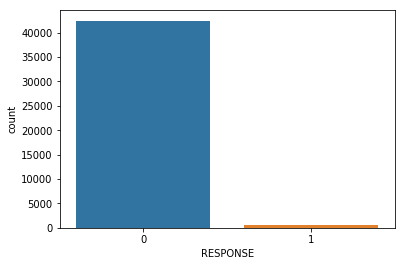

In [7]:
# Visualize the distribution of y - RESPONSE
sns.countplot(y)

In [278]:
def grid_search(estimator, param_grid, X=X, y=y):
    """
    Grid search a classifier by ROC AUC score, using cross-validation.
    
    INPUT:
    - estimator (classifier): name of classifier
    - param_grid (dict): parameters used with GridSearchCV
    - X (DataFrame): features from cleaned mailout_train dataframe
    - y (DataFrame): 'RESPONSE' from cleaned mailout_train dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    best_estimator = grid.best_estimator_
    best_score = grid.best_score_
    return best_estimator, best_score

In [279]:
# Choose five classifiers, LR, RF, AB, XGB, and GB
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [41]:
# Ignore the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [42]:
# Evaluate ROC AUC score of five classifiers with default parameter
for i in range(len(models)):
    score = grid_search(models[i][1], {})[1]
    print('ROC AUC score for {}: {}'.format(models[i][0], score))

ROC AUC score for LR: 0.6485425679155218
ROC AUC score for RF: 0.51397198920462
ROC AUC score for AB: 0.7172247047271816
ROC AUC score for XGB: 0.6767631187538438
ROC AUC score for GB: 0.756353542860312


**Discussion:** According to above result, I decided to take Top 2 classifiers, AdaBoostClassifier and GradientBoostingClassifier. Tuning hyperparameter of them to improve the score.

In [45]:
# Tune the hyperparameters of AB model
param_AB = {
          "learning_rate"     : [0.1,0.2],
          "n_estimators"      : [100,200,500]}
AB_tuned = grid_search(AdaBoostClassifier(), param_AB)

In [48]:
print(AB_tuned[0],AB_tuned[1])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None) 0.7531099681186055


In [49]:
# Tune the hyperparameters of GB model
param_GB = {
          "learning_rate"     : [0.1,0.2],
          "max_depth"         : [3,4],
          "n_estimators"      : [100,200],
          "min_samples_split" : [2,4]}
GB_tuned = grid_search(GradientBoostingClassifier(), param_GB)

In [52]:
print(GB_tuned[0], GB_tuned[1])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 0.7569571470247872


In [280]:
# Re-fit the models with tuned parameters
model_AB = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None).fit(X, y)

model_GB = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False).fit(X, y)

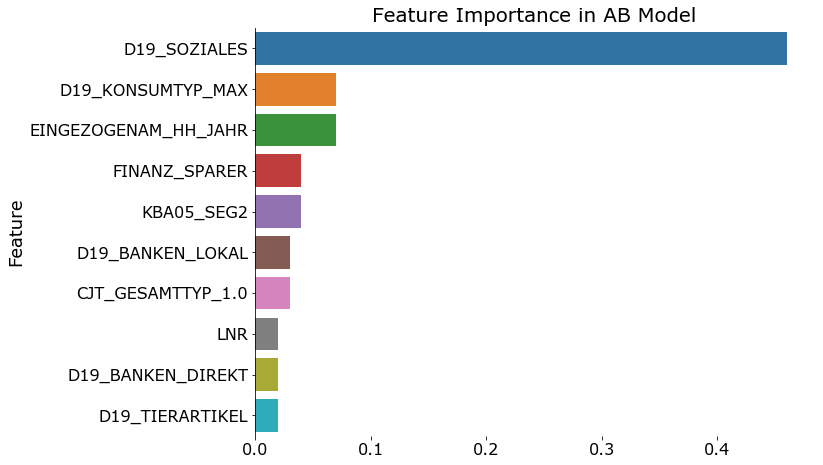

In [313]:
AB_importance = pd.DataFrame({'feature': X.columns, 'importance':model_AB.feature_importances_}).nlargest(10,columns='importance')
AB_importance.sort_values('importance',ascending = False, inplace=True)
fig = plt.figure(figsize=(10,7.5))
ax = sns.barplot(y = AB_importance['feature'], x = AB_importance['importance'])
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('Feature', fontname="verdana").set_size(18)
plt.xlabel('', fontname="verdana").set_size(18)
plt.xticks(fontsize=16, fontname="verdana")
plt.yticks(fontsize=16, fontname="verdana")
plt.title('Feature Importance in AB Model', fontname="verdana").set_size(20)
plt.savefig('AB_importance.png', bbox_inches='tight')

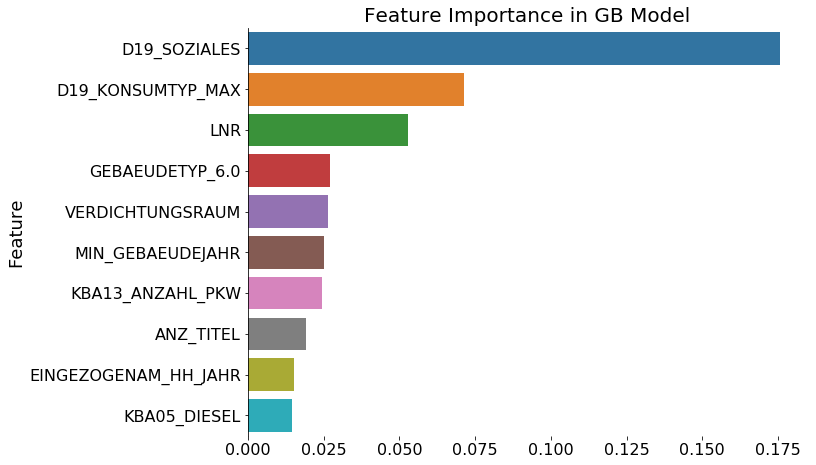

In [290]:
GB_importance = pd.DataFrame({'feature': X.columns, 'importance':model_GB.feature_importances_}).nlargest(10,columns='importance')
GB_importance.sort_values('importance', ascending = False, inplace=True)
fig = plt.figure(figsize=(10,7.5))
ax = sns.barplot(y = GB_importance['feature'], x = GB_importance['importance'])
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
plt.ylabel('Feature').set_size(18)
plt.xlabel('').set_size(18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Feature Importance in GB Model').set_size(20)

**Discussion:** AdaBoostClassifier (AB) and GradientBoostClassifier (GB) can achieve relatively higher performance than the other, with the ROC AUC score 0.7172 and 0.7564. After hyperparameter tuning, their performance can increase to 0.7531 in AB, 0.7564 in GB. The most important feature is "D19_SOZIALES" in both AB and GB, it is more likely describe a individual has any transaction related with social.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [10]:
# Load mailout_test dataframe
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Clean the mailout_test dataframe
test_clean = clean(mailout_test)

Step 1 - Fix mixed-type issue
Shape after Step 1: (42833, 366)
Step 2 - Convert NaN


/Users/zhili/Documents/Arvato Project/clean.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feature_notnull['missing_or_unknown'] = feature_notnull['missing_or_unknown'].apply(lambda x: x.split(','))


Shape after Step 2: (42833, 366)
Step 3 - Drop column with >30% missing rate
Shape after Step 3: (42833, 345)
Step 4 - Drop highly correlated features
Shape after Step 4: (42833, 334)
Step 5 - Re-encode categorical features
Shape after Step 5: (42833, 371)
Step 6 - Transform some mix-type features
Shape after Step 6: (42833, 395)
Step 7 - Impute missing value
Shape after Step 7: (42833, 395)
Step 8 - Scale the values
Shape after Step 8: (42833, 395)


In [12]:
# Find whether there is missing feature between train_clean and test_clean
np.setdiff1d(train_clean.columns, test_clean.columns)

array(['KBA13_BAUMAX', 'RESPONSE'], dtype=object)

In [13]:
# Prepare the missing 'KBA13_BAUMAX' in test_clean from original mailout_test, impute the missing value with mode
test_to_add = pd.DataFrame(mailout_test.KBA13_BAUMAX)
test_to_add['KBA13_BAUMAX'] = test_to_add['KBA13_BAUMAX'].fillna(test_to_add['KBA13_BAUMAX'].mode()[0])

In [14]:
# Scale the value of 'KBA13_BAUMAX', join the imputed&scaled feature to test_clean
scaler = StandardScaler()
test_to_add = pd.DataFrame(scaler.fit_transform(test_to_add.values),columns=test_to_add.columns)
test_clean = test_clean.join(test_to_add)

In [90]:
# Predict the RESPONSE by model_AB
pred_AB = model_AB.predict_proba(test_clean)

In [91]:
# Predict the RESPONSE by model_GB
pred_GB = model_GB.predict_proba(test_clean)

In [102]:
# Create dataframe index with 'LNR', containing model_AB predicted RESPONSE for Kaggle competition
AB_df = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=pred_AB[:,1])
AB_df.rename(columns={0: "RESPONSE"}, inplace=True)
AB_df.to_csv('AB_kaggle.csv')

In [103]:
# Create dataframe index with 'LNR', containing model_GB predicted RESPONSE for Kaggle competition
GB_df = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=pred_GB[:,1])
GB_df.rename(columns={0: "RESPONSE"}, inplace=True)
GB_df.to_csv('GB_kaggle.csv')